<a href="https://colab.research.google.com/github/Nekokan1500/Machine-Learning/blob/main/Deep_Learning/Example_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml

fashion_mnist = fetch_openml(data_id=40996)

labels_s = '0 T-shirt/top \n1 Trouser \n2 Pullover \n3 Dress \n4 Coat \n5 Sandal \n6 Shirt \n7 Sneaker \n8 Bag \n9 Ankle boot'
fashion_label_translation = {int(k): v for k, v in [item.split(maxsplit=1) for item in labels_s.split('\n')]}

def translate_label(y, translation=fashion_label_translation):
  return pd.Series(y).apply(lambda y: translation[int(y)]).values

def display_fashion(img, target, ax):
  if len(img.shape):
    w = int(np.sqrt(img.shape[0]))
    img = img.reshape((w, w))
  ax.imshow(img, cmap='Greys')
  ax.set_title(f'{target}')
  ax.grid(False)

In [2]:
# Take 10000 images from the dataset and split into training and test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

fashion_mnist_sample = {}
fashion_mnist_sample['data'], _, fashion_mnist_sample['target'], _ = train_test_split(fashion_mnist['data'], fashion_mnist['target'], train_size=10000)

x, y = fashion_mnist_sample['data'], fashion_mnist_sample['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

translation = fashion_label_translation
y_train_translated = translate_label(y_train, translation=translation)
y_test_translated = translate_label(y_test, translation=translation)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_translated)
y_test_encoded = le.transform(y_test_translated)

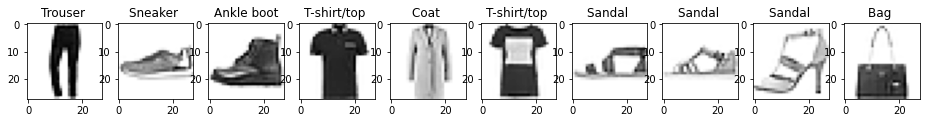

In [3]:
# display the images
import random
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 10, figsize=(16,12))
for i in range(10):
  rand = random.choice(range(x_train.shape[0]))
  display_fashion(x_train[rand], y_train_translated[rand], ax=axs[i])
fig.show()

In [4]:
# Training a neural network model
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(100,100), max_iter=500)
clf.fit(x_train, y_train_encoded)
y_test_pred = clf.predict(x_test)

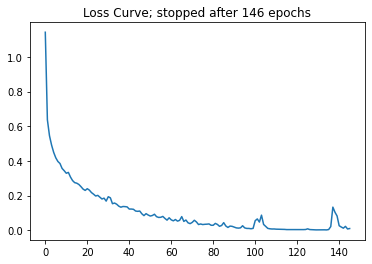

In [5]:
pd.Series(clf.loss_curve_).plot(title=f'Loss Curve; stopped after {clf.n_iter_} epochs')

1

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.1

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.01

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.001

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.0001

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


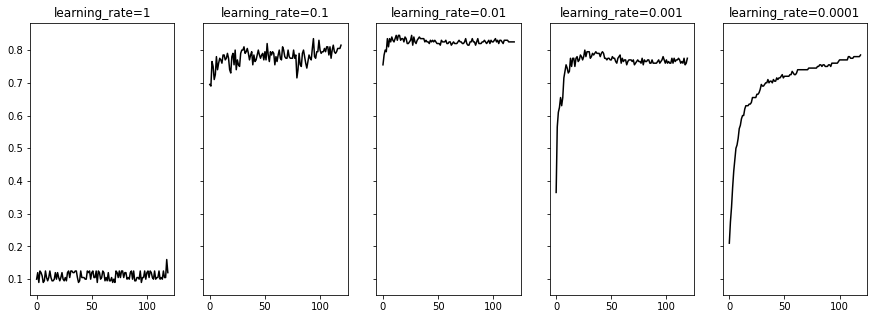

In [7]:
# Trying different learning rates
learning_rate_init_options = [1, 0.1, 0.01, 0.001, 0.0001]

fig, axs = plt.subplots(1, len(learning_rate_init_options), figsize=(15,5), 
                        sharex=True, sharey=True)

for i, learning_rate_init in enumerate(learning_rate_init_options):
  print(f'{learning_rate_init}', end='')
  clf = MLPClassifier(
      hidden_layer_sizes=(500,),
      learning_rate='constant',
      learning_rate_init=learning_rate_init,
      validation_fraction=0.2,
      early_stopping=True,
      n_iter_no_change=120,
      max_iter=120,
      solver='sgd',
      batch_size=25,
      verbose=0
  )
  clf.fit(x_train[:1000,:],y_train_encoded[:1000])
  pd.Series(clf.validation_scores_).plot(
      title=f'learning_rate={learning_rate_init}',
      kind='line',
      color='k',
      ax=axs[i]
  )

fig.show()

In [ ]:
# Trying different batch sizes
batch_sizes = [1, 10, 100, 1500]

fig, axs = plt.subplots(1, len(batch_sizes), figsize=(15,5), sharex=True, sharey=True)

for i, batch_size in enumerate(batch_sizes):
  print(f'{batch_size} ', end='')
  clf = MLPClassifier(
      hidden_layer_sizes=(500,),
      learning_rate='constant',
      learning_rate_init=0.001,
      momentum=0,
      max_iter=250,
      early_stopping=True,
      n_iter_no_change=250,
      solver='sgd',
      batch_size=batch_size,
      verbose=0
  )
  clf.fit(x_train[:1500,:],y_train_encoded[:1500])
  pd.Series(clf.validation_scores_).plot(
      title=f'batch_size={batch_size}',
      color='k',
      kind='line',
      ax=axs[i]
  )

fig.show()


[learning_curve] Training set sizes: [ 266  533 1333 2666 3999 5333]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:  1.2min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  3.4min finished


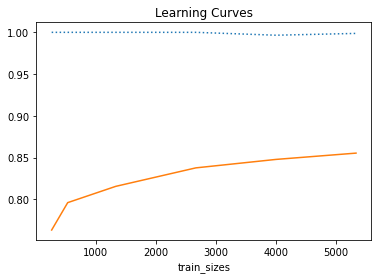

In [9]:
# Trying different training set sizes
from sklearn.model_selection import learning_curve

train_sizes = [1, 0.75, 0.5, 0.25, 0.1, 0.05]

train_sizes, train_scores, test_scores = learning_curve(
    MLPClassifier(
        hidden_layer_sizes=(100,100),
        solver='adam',
        early_stopping=False
    ),
    x_train, y_train_encoded, train_sizes=train_sizes,
    scoring="precision_macro",
    cv=3,
    verbose=2,
    n_jobs=-1
)

df_learning_curve = pd.DataFrame(
    {
        'train_sizes': train_sizes,
        'train_scores': train_scores.mean(axis=1),
        'test_scores': test_scores.mean(axis=1)
    }
).set_index('train_sizes')

df_learning_curve['train_scores'].plot(title='Learning Curves', ls=':')
df_learning_curve['test_scores'].plot(title='Learning Curves', ls='-')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:  1.8min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  3.9min finished


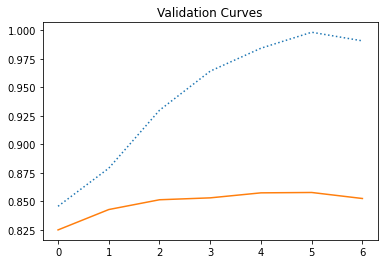

In [11]:
# Trying different numbers of epochs (max iterations)
from sklearn.model_selection import validation_curve

max_iter_range = [5, 10, 25, 50, 75, 100, 150]

train_scores, test_scores = validation_curve(
    MLPClassifier(
        hidden_layer_sizes=(100,100),
        solver='adam',
        early_stopping=False
    ),
    x_train, y_train_encoded, param_name='max_iter', param_range=max_iter_range,
    scoring="precision_macro",
    cv=3,
    verbose=2,
    n_jobs=-1
)

df_validation_curve = pd.DataFrame(
    {
        'train_scores': train_scores.mean(axis=1),
        'test_scores': test_scores.mean(axis=1)
    }
)

df_validation_curve['train_scores'].plot(title='Validation Curves', ls=':')
df_validation_curve['test_scores'].plot(title='Validation Curves', ls='-')